# Práctica: Redes Bayesianas Multinomiales

### *Master in Data Science - Machine Learning II*

### *Santander Meteorology Group*

## 1 Introducción a la práctica

La presente práctica esta concebida como una primera aproximación a los fundamentos de la Redes Bayesianas. Utilizaremos los datos de una encuesta sobre utilización de medios de transporte. La práctica se centra en la modelización de variables discretas mediante una *Red Bayesiana Multinomial*.

Este tipo de red se construye con variables aleatorias discretas, es decir, que cada variable tiene un número finito de posibles estados. Asimismo, se considera que la probabilidad condicional de cada variable dados sus padres es multinomial, y por lo tanto, ésta viene dada por la tabla de probabilidades correspondientes a las diferentes combinaciones de estados entre las variables implicadas.

La práctica ilustra los pasos a seguir en entorno R para:

  1. Construir un grafo acíclico dirigido (DAG, de las siglas en inglés de directed acyclic graph)
  2. Definición de la función de probabilidad conjunta (FPC)
  3. Definición de los parámetros del modelo (*aprendizaje paramétrico*)
  4. Obtener nueva información a partir de una evidencia dada (*inferencia*)
  5. Aprendizaje automático del grafo de una red bayesiana a partir de los datos (*aprendizaje estructural*)
  6. Representación gráfica del modelo


### 1.1 Dataset de ejemplo: 'survey'

A partir de los datos de campo recogidos por la encuesta, se investigará la selección de medios de transporte por distintos perfiles de usuarios, y particularmente a la preferencia de tren o coche. Este tipo de análisis se utilizan con frecuencia en la planificación de infraestructuras. Para cada individuo encuestado, se han recopilado datos referenctes a 6 variables discretas. Las abreviaturas de dichas variables se muestran entre paréntesis, y se utilizarán a lo largo de la práctica para referirse a los nodos de la red creada. Tanto las abreviaturas como los nombres de las variables preservan la nomenclatura original del dataset en inglés.

  * Edad (`A`): Edad del encuestado, agrupado en los siguientes estados: joven (`young`, < 30 años), adulto (`adult`, 30 < edad <= 60) y anciano (`old`, edad > 60).
  * Sexo (`S`): Sexo del encuestado, con sus dos posibles estado: masculino (`M`) y femenino (`F`).
  * Educación (`E`): Nivel más alto de educación alcanzado. Hasta educación secundaria (`high`) o título universitario (`uni`).
  * Ocupación (`O`): Considera dos estados: trabajador por cuenta ajena (`emp`) o autónomo (`self`).
  * Residencia (`R`): El tamaño de la población de residencia del individuo. Estados posibles: `big` y `small`.
  * Transporte (`T`): El medio de transporte más utilizado por el encuestado para acudir al trabajo, diferenciando 3 posibles estados: `car`, `train` y `other`.

### 1.2 Paquetes de R necesarios

Se utilizará el paquete de R `bnlearn` (**b**ayesian **n**etwork **lear**ning), disponible a través del CRAN. Por tanto, su instalación es directa si no lo tenemos previamente instalado:

```r
if (!require(bnlearn)) install.packages("bnlearn")
```

Además, se necesitan dependencias adicionales para la parte relacionada con la inferencia:

```r
# Paquete RBGL (disponible en bioconductor)
if (!require(RBGL)) {
      source("http://bioconductor.org/biocLite.R")
      biocLite("RBGL")
}
# Paquete gRain
if (!require(gRain)) install.packages("gRain")
```

y para la parte de visualización de grafos:

```r
if (!require(Rgraphviz)) {
    source("http://bioconductor.org/biocLite.R")
    biocLite("Rgraphviz")
}
```

In [1]:
library('bnlearn')
library(RBGL)
library(gRain)
library(Rgraphviz)


Attaching package: ‘bnlearn’

The following object is masked from ‘package:stats’:

    sigma

Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:bnlearn’:

    score

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rowna

## 2 Construcción de la red Bayesiana

### 2.1 Dibujar la estructura de la red

Para crear un grafo que contenga un nodo por cada variable considerada en la encuesta utilizamos la función `empty.graph`:

In [2]:
dag <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

Nombramos a nuestro grafo vacío `dag`, que es un acrónimo de *directed acyclic graph*, o gráfico acíclico dirigido, en referencia a las principales propiedades de este tipo de grafos, y que ya sen visto durante las sesiones teórico-prácticas.

Esta es la información contenida en el grafo, que es un objeto de la clase `bn`:

[1] "bn"


  Random/Generated Bayesian network

  model:
   [A][S][E][O][R][T] 
  nodes:                                 6 
  arcs:                                  0 
    undirected arcs:                     0 
    directed arcs:                       0 
  average markov blanket size:           0.00 
  average neighbourhood size:            0.00 
  average branching factor:              0.00 

  generation algorithm:                  Empty 



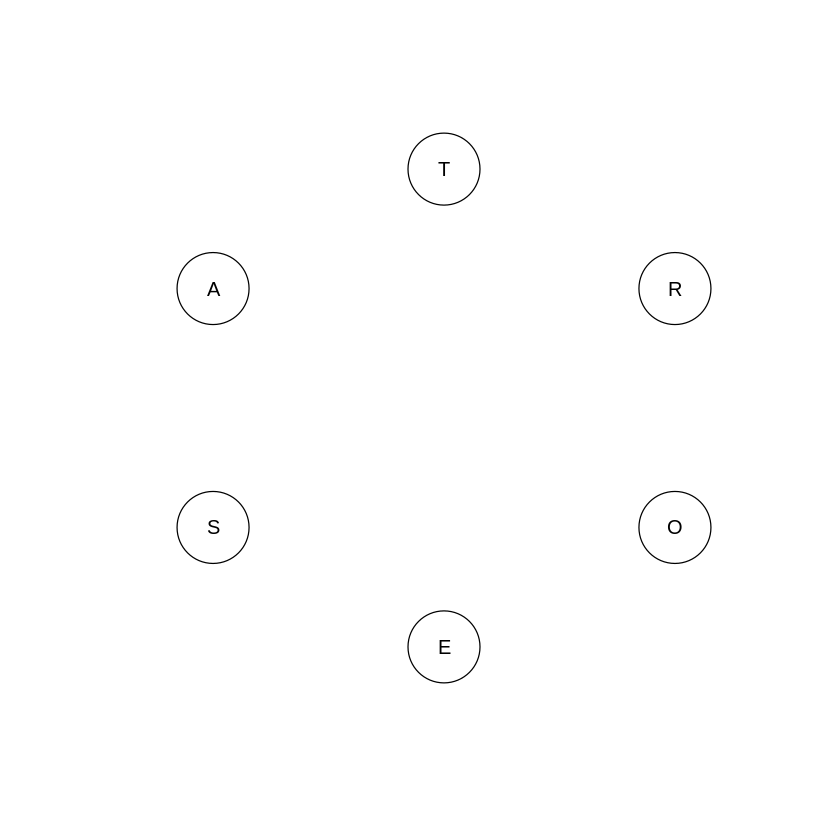

In [3]:
class(dag)
print(dag)
plot(dag)

En [secciones posteriores](#draw.dag) veremos como hacer representaciones gráficas más detalladas, pero de momento basta con aplicar el método `plot` para ir viendo la estructura básica de la red. Una vez creados los nodos, comenzamos a añadir los arcos que definen las dependencias directas entre las diferentes variables. 

La edad y el sexo son indicadores demográficos y no reciben influencia de ninguna otra variable, ya que son características intrínsecas del individuo. Por lo tanto, ninguno de los arcos del grafo apuntan hacia ellas. Por otra parte, ambas variables (sexo y edad) si tienen una influencia directa sobre el nivel de educación, ya que el número de estudiantes universitarios ha aumentado en las últimas décadas, y por lo tanto personas más jóvenes tienen más probabilidad de tener un título universitario que otras más mayores.

In [4]:
dag <- set.arc(dag, from = "A", to = "E")

Del mismo modo, el sexo tiene influencia sobre la educación, ya que las estadísticas demuestran que en la actualidad hay un mayor número de mujeres que de hombres completando estudios universitarios.

In [5]:
dag <- set.arc(dag, from = "S", to = "E")

Tras añadir dos arcos, este es el aspecto que va tomando el grafo:

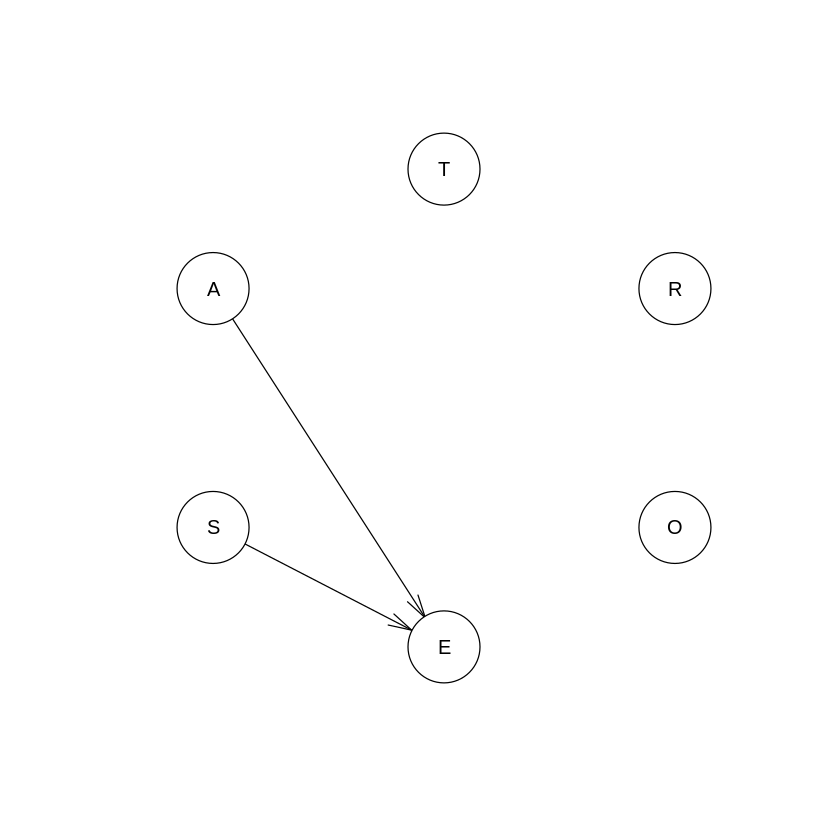

In [6]:
plot(dag)

El nivel de educación tiene una fuerte influencia en la ocupación del individuo, así como en su lugar de residencia:

In [7]:
dag <- set.arc(dag, from = "E", to = "O")
dag <- set.arc(dag, from = "E", to = "R")

Finalmente, los medios de transporte preferidos por el individuo están directamente influidos por su lugar de residencia y su ocupación. En cuanto al primer factor, la distancia al lugar de trabajo desde la residencia influye directamente en la opción de transporte. Por otra parte, algunos trabajos requieren viajes periódicos de larga distancia, mientras que otros requieren trayectos más frecuentes sobre cortas distancias.

In [8]:
dag <- set.arc(dag, from = "R", to = "T")
dag <- set.arc(dag, from = "O", to = "T")

Finalmente, asi queda definido el grafo:

In [9]:
dag


  Random/Generated Bayesian network

  model:
   [A][S][E|A:S][O|E][R|E][T|O:R] 
  nodes:                                 6 
  arcs:                                  6 
    undirected arcs:                     0 
    directed arcs:                       6 
  average markov blanket size:           2.67 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  generation algorithm:                  Empty 


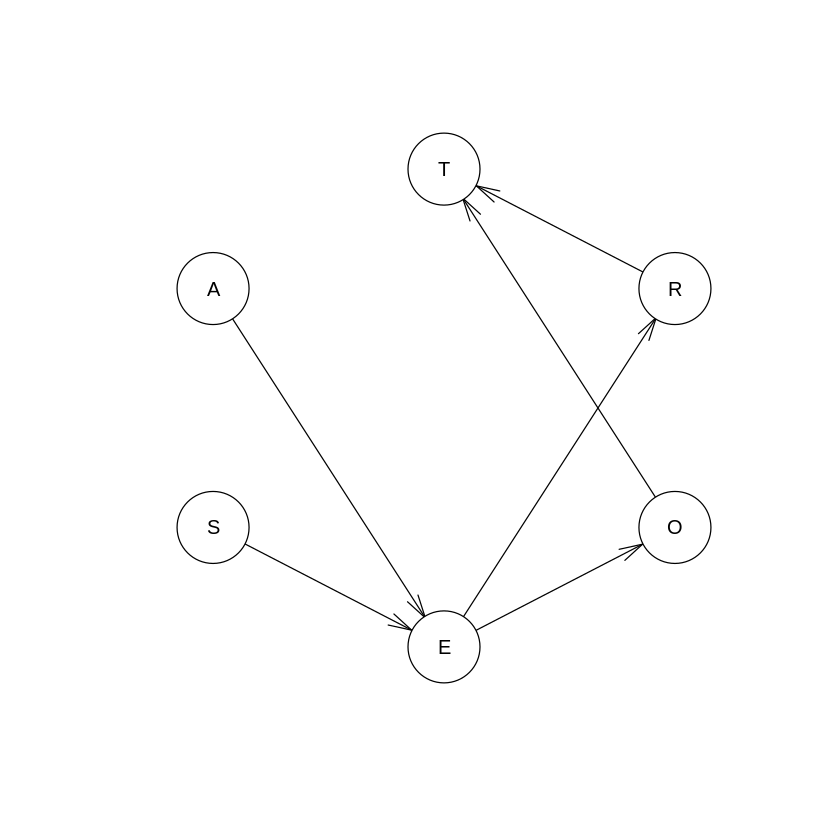

In [10]:
plot(dag)

Esta es la definición simbólica del grafo:

In [11]:
modelstring(dag)

[1] "[A][S][E|A:S][O|E][R|E][T|O:R]"

De este modo, las dependencias de cada variable quedan definidas por una barra vertical (`|`) y separadas por dos puntos `:`. Por ejemplo, `[E|A:S]` significa que `A --> E` (_edad influye sobre empleo_) y `S --> E` (_sexo influye sobre empleo_). Esta notación se asemeja a un producto de probabilidades condicionales, del tipo $P(E|A,S)$. Esto equivale a la expresión de la factorización de la distribución global hecha por nuestra red (Eq. 1):

$$P(A,S,E,O,R,T) = P(A)P(S)P(E|A,S)P(O|E)P(R|E)P(T|O,R)$$

Otras funciones útiles para explorar objetos de la clase `bn` son por ejemplo `nodes`y `arcs`:

In [12]:
nodes(dag)

[1] "A" "S" "E" "O" "R" "T"

In [13]:
arcs(dag)

from,to
A,E
S,E
E,O
E,R
R,T
O,T


#### 2.1.1 Forma alternativa para dibujar el DAG de forma más directa

La función `arcs` es especialmente interesante ya que nos permite añadir arcos de manera más rápida. En este caso, se podrían definir las relaciones mediante una matriz de dos columnas similar a la devuelta por `arcs`:

In [14]:
dag2 <- empty.graph(nodes = c("A", "S", "E", "O", "R", "T"))

In [15]:
arc.set <- matrix(c("A", "E",
                    "S", "E",
                    "E", "R",
                    "E", "O",
                    "O", "T",
                    "R", "T"),
                  byrow = TRUE, ncol = 2,
                  dimnames = list(NULL, c("from", "to")))

In [16]:
arcs(dag2) <- arc.set

El grafo resultante es idéntico al que se generó anteriormente:

In [17]:
all.equal(dag, dag2)

[1] TRUE

Ambas formas de definir el grafo garantizan que éste sea acíclico, ya que si se intenta introducir un ciclo en el mismo se producirá un error. Por ejemplo, si intentamos crear una relación directa entre `T` y `E`, lo que daría lugar a un ciclo, se produce un error:

In [18]:
try(set.arc(dag, from = "T", to = "E"))

```
## Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles,  : 
##   the resulting graph contains cycles.
```

### 2.2 Representacion probabilística de la red Bayesiana

#### 2.2.1 Definición de los estados de las variables

Una vez representadas las interacciones entre variables mediante el grafo, es necesario especificar una distribución de probabilidad conjunta sobre todas las variables para obtener el modelo bayesiano de los datos de la encuesta. Todas ellas, como se dijo al principio, son variable discretas y definidas para una serie de estados ordenados (categorías, o `levels` en R), que se definen a continuación:

In [21]:
estados.A <- c("young", "adult", "old")
estados.S <- c("M", "F")
estados.E <- c("high", "uni")
estados.O <- c("emp","self")
estados.R <- c("small","big")
estados.T <- c("car","train","other")

En este caso, la distribución de probabilidad conjunta viene dada por una [distribución multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution) (ver `help("dmultinom")` para [más detalles](https://stat.ethz.ch/R-manual/R-patched/library/stats/html/Multinom.html)), asignando una probabilidad a cada una de las combinaciones de los posibles estados de las variables de la encuesta. Es lo que denominamos la *distribución global*.

El problema, como se ha visto anteriormente, surge del hecho de que usar la distribución global directamente es difícil (cuando no completamente inviable), debido al gran número de parámetros a la que puede dar lugar. En este caso particular, considerar la distribución global daría lugar a $3 * 2 * 2 * 2 * 2 * 3 - 1$ parámetros, es decir 143 probabilidades correspondientes a todas las posibles combinaciones de los niveles de todas las variables. En su lugar, hemos utilizado un  modelo mucho más parsimonioso a partir del grafo, descartando muchas relaciones entre variables que sabemos *a priori* que no tienen sentido (p. ej. la relación entre la edad `A` y el sexo `S` del encuestado). Las variables que no se encuentran unidas por ningún arco se dice que son *condicionalmente independientes*. Por lo tanto, la factorización representada por la ecuación 1.1. es un submodelo de la distribución global que contiene muchos menos parámetros.

#### 2.2.2 Definición de probabilidades

Dado que las probabilidades condicionales pueden ser unidimensionales o venir en forma de tablas de varias dimensiones dependiendo del número de padres de cada nodo, utilizaremos para crear dichas probabilidades la función `array`, que permite utilizar una interfaz común en todos los casos. Nótese no obstante que para probabilidades unidimensionales (variables sin padres) o para tablas de dos dimensiones (variables con un padre) puede utilizarse alternativamente la función `matrix`. A continuación veremos ejemplos.

En la encuesta, la Edad y el Sexo vienen dadas por probabilidades unidimensionales, ya que son variables que no tienen *padres* en el grafo. 

In [24]:
A.prob <- array(c(.3, .5, .2), dim = 3, dimnames = list(A = estados.A))
print(A.prob)

A
young adult   old 
  0.3   0.5   0.2 


In [25]:
S.prob <- array(c(.6, .4), dim = 2, dimnames = list(S = estados.S))
print(S.prob)

S
  M   F 
0.6 0.4 


Ocupación y residencia, al depender de Educación, se representan mediante una tabla de probabilidades condicionadas de dos dimensiones. Cada columna en este caso representa cada uno de los niveles del padre, y mantiene la distribución de la variable condicionada cada nivel particular, por lo que las probabilidades de 
cada columna siempre suman 1:

In [26]:
O.prob <- array(c(.96,.04,.92,.08), dim = c(2,2), 
                  dimnames = list(O = estados.O, E = estados.E))
print(O.prob)

      E
O      high  uni
  emp  0.96 0.92
  self 0.04 0.08


In [27]:
R.prob <- array(c(.25,.75,.2,.8), dim = c(2,2), 
                  dimnames = list(R = estados.R, E = estados.E))
print(R.prob)

       E
R       high uni
  small 0.25 0.2
  big   0.75 0.8


Por último, Educación y Transporte se modelizan en forma de tablas 3-dimensionales, dado que tienen 2 padres cada una. Cada columna corresponde en este caso a una combinación de los niveles de los padres y contienen la probabilidad de la variable condicionada a esa combinación particular:

In [28]:
# Tabla de probabilidades condicionales para el nodo Educacion
E.prob <- array(c(.75, .25, .72, .28, .88, .12, .64, .36, .70, .30, .90, .10),
                dim = c(2, 3, 2),
                dimnames = list(E = estados.E,
                                A = estados.A,
                                S = estados.S))
print(E.prob)

, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult old
  high  0.64   0.7 0.9
  uni   0.36   0.3 0.1



In [29]:
# Tabla de probabilidades condicionales para el nodo Transporte
T.prob <- array(c(.48, .42, .1, .56, .36, .08, .58, .24, .18, .7, .21, .09),
                dim = c(3,2,2),
                dimnames = list(T = estados.T, 
                                O = estados.O,
                                R = estados.R))
print(T.prob)

, , R = small

       O
T        emp self
  car   0.48 0.56
  train 0.42 0.36
  other 0.10 0.08

, , R = big

       O
T        emp self
  car   0.58 0.70
  train 0.24 0.21
  other 0.18 0.09



Una vez definidos el grafo y la distribución de las probabilidades locales de cada variable, se combinan para crear la red bayesiana propiamente dicha. Para ello, se almacenan las diferentes tablas de probabilidades condicionadas en una lista (`named list` en R), en la que cada elemento lleva el nombre la variable correspondiente (la llamamos `cpt`, de _conditional probability tables_):

In [30]:
cpt <- list(A = A.prob, S = S.prob, E = E.prob, O = O.prob, R = R.prob, T = T.prob)
str(cpt)

List of 6
 $ A: num [1:3(1d)] 0.3 0.5 0.2
  ..- attr(*, "dimnames")=List of 1
  .. ..$ A: chr [1:3] "young" "adult" "old"
 $ S: num [1:2(1d)] 0.6 0.4
  ..- attr(*, "dimnames")=List of 1
  .. ..$ S: chr [1:2] "M" "F"
 $ E: num [1:2, 1:3, 1:2] 0.75 0.25 0.72 0.28 0.88 0.12 0.64 0.36 0.7 0.3 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ E: chr [1:2] "high" "uni"
  .. ..$ A: chr [1:3] "young" "adult" "old"
  .. ..$ S: chr [1:2] "M" "F"
 $ O: num [1:2, 1:2] 0.96 0.04 0.92 0.08
  ..- attr(*, "dimnames")=List of 2
  .. ..$ O: chr [1:2] "emp" "self"
  .. ..$ E: chr [1:2] "high" "uni"
 $ R: num [1:2, 1:2] 0.25 0.75 0.2 0.8
  ..- attr(*, "dimnames")=List of 2
  .. ..$ R: chr [1:2] "small" "big"
  .. ..$ E: chr [1:2] "high" "uni"
 $ T: num [1:3, 1:2, 1:2] 0.48 0.42 0.1 0.56 0.36 0.08 0.58 0.24 0.18 0.7 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ T: chr [1:3] "car" "train" "other"
  .. ..$ O: chr [1:2] "emp" "self"
  .. ..$ R: chr [1:2] "small" "big"


Y se crea la red bayesiana con la función `custom.fit`:

In [31]:
bn <- custom.fit(dag, cpt)

El objeto `bn` es la red bayesiana completa (grafo + tablas de probabilidad asociadas a cada nodo).

In [32]:
class(bn)

[1] "bn.fit"      "bn.fit.dnet"

In [34]:
bn$E$prob

, , S = M

      A
E      young adult  old
  high  0.75  0.72 0.88
  uni   0.25  0.28 0.12

, , S = F

      A
E      young adult  old
  high  0.64  0.70 0.90
  uni   0.36  0.30 0.10


## 3 Inferencia

La utilidad de la red probabilística radica en último término hallar de forma eficiente la probabilidad de cualquier nodo (o conjunto de nodos), dada una cierta información (*evidencia*). Este proceso se denomina *inferencia* o razonamiento probabilístico. Una red bayesiana puede utilizarse para hacer inferencia bien a través de su DAG, o través del conjunto de distribuciones locales definido. Básicamente, el tipo de cuestiones que podemos plantearle a nuestra red bayesiana, como si de un sistema experto se tratara, son tres tipos:

  1. Las probabilidades de que ocurra un evento bajo unas circunstancias específicas, es decir, _consultas de probabilidad condicionada_
  2. Validar la asociación entre dos variables una vez que la influencia de una tercera es descartada, es decir, _consultas de independencia condicional_
  3. Identificar el estado más probable de una o más variables, lo cual lleva a la _explicación más probable_.

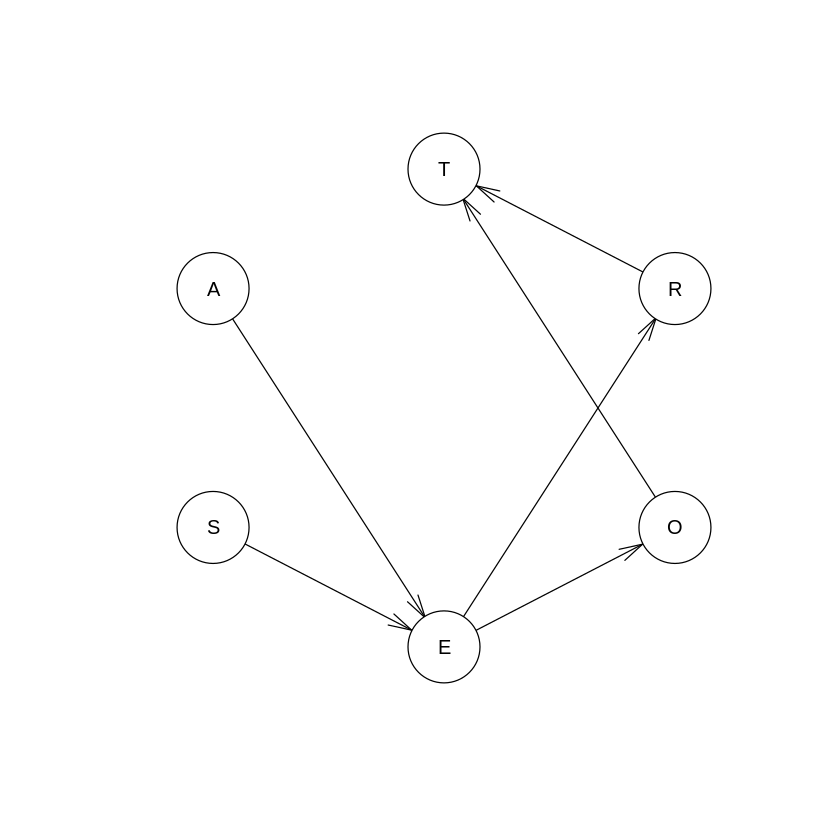

In [37]:
#::GMG::Recordamos el DAG que tenemos entre manos :)
plot(dag)

### 3.1 Inferencia a partir de la estructura del DAG: _d-separación_

Podemos estudiar la asociación entre variables con la información contenida en nuestro grafo, almacenado en el objeto `dag`, mediante una consulta de probabilidad condicionada. Esto es posible mediante un análisis entre las conexiones del DAG, para comprobar si existe alguna conexión entre ellas, bien sea directa o indirecta, dependiendo de si la relación entre las dos variables está mediada por uno o más arcos respectivamente. Si no existe dicha conexión entre las variables en el grafo, hablamos de separación dirigida, o _d-separación_. Los detalles de la d-separación ya se han visto anteriormente. En esta práctica, basta con recordar que la separación gráfica de dos variables ($\perp_{G}$) implica independencia probabilística ($\perp_{P}$) en la red bayesiana. Si todas las trayectorias entre $X$ e $Y$ se encuentran bloqueadas, se dice que $X$ e $Y$ son (condicionalmente) independientes dada una tercera variable $Z$, lo que representamos como $X \perp_{G} Y | Z$. Lo contrario no es necesariamente cierto: no todas las relaciones de independencia condicional se encuentran reflejadas en el grafo.

Podemos investigar la d-separación entre variables de un grafo con la función `dsep`:

In [35]:
dsep(dag, x = "S", y = "R")

[1] FALSE

In [36]:
dsep(dag, x = "O", y = "R")

[1] FALSE

En los anteriores ejemplos las variables introducidas no son independientes. Esto podemos verlo en el grafo, donde el sexo (`S`) y el lugar de residencia (`R`) están conectados a través de educación (`E`). Del mismo modo, la ocupación (`O`) y el lugar de residencia están relacionadas a través de la educación (`E`).

De hecho, podemos comprobar que hay una conexión entre `S` y `R` el el DAG:

In [38]:
bnlearn::path(dag, from = "S", to = "R")

[1] TRUE

pero si condicionamos a la educación, la conexión queda bloqueada y `S` y `R` son ahora independientes:

In [39]:
dsep(dag, x = "S", y = "R", z = "E")

[1] TRUE

Lo mismo aplica a la relación entre `O` y `R`. Ambas dependen de `E`, y por lo tanto ambas se vuelven independientes cuando condicionamos sobre `E`:

In [40]:
dsep(dag, "O", "R", "E")

[1] TRUE

Por el contrario, condicionar sobre un nodo particular puede también hacer que otros nodos marginalmente independientes pasen a ser dependientes. Por ejemplo, 

In [41]:
dsep(dag, x = "A", y = "S")

[1] TRUE

In [42]:
dsep(dag, x = "A", y = "S", z = "E")

[1] FALSE

Efectivamente, si queremos hacer inferencia sobre el nodo `A` en este caso, necesitaremos además información sobre los nodos `S` y `E`. Este subconjunto de nodos constituye el _Markov blanket_ de `A`, siendo el resto de los nodos del grafo redundantes para hacer inferencia sobre `A`:

In [43]:
bnlearn::mb(dag, "A")

[1] "S" "E"

Sabemos a partir del grafo que el estado de `E` esta influenciado por los estados de `A` y `S`, que son sus padres.

In [44]:
bnlearn::parents(dag, "E")

[1] "A" "S"

A su vez, `A` y `S` pasan a ser dependientes dado `E`. De forma equivalente, `E` depende de la distribución conjunta de `A` y `S`, $P(\mathrm{\texttt{E|A,s}})$; por tanto, de acuerdo con el Teorema de Bayes, tenemos:

$$
\begin{aligned}
P(\mathrm{\texttt{E|A,S}}) = \frac{P(\mathrm{\texttt{A,S,E}})}{P(\mathrm{\texttt{A,S}})} = \frac{P(\mathrm{\texttt{A,S|E}})P(\mathrm{\texttt{E}})}{P(\mathrm{\texttt{A}})P(\mathrm{\texttt{S}})} \alpha P(\mathrm{\texttt{A,S|E}})
\end{aligned}
$$

, y por lo tanto cuando `E` es conocida, no podemos descomponer la probabilidad conjunta de `A` y `S` en una parte que dependa sólo de `A` y otra de `S`. No obstante, $P(\mathrm{\texttt{A,S}}) = P(\mathrm{\texttt{A|S}})P(\mathrm{\texttt{S}}) = P(\mathrm{\texttt{A}})P(\mathrm{\texttt{S}})$: tal y como se ha visto en el ejemplo anterior, `A` y `S` están d-separadas cuando no se condiciona a `E`.


Estos tres ejemplos de relaciones condicionadas entre variables recogen las tres configuraciones básicas de tres nodos y dos arcos. Se conocen como _conexiones fundamentales_ y son los bloques sobre los que se fundamentan las propiedades gráficas y probabilísticas de las redes bayesianas. Puedes repasar las diapositivas de la parte teórica, pero simplemente para fijar conceptos, estas son las tres conexiones fundamentales:

  * Conexiones en serie (cascada): del tipo: `S -> E -> R`, como en el primer ejemplo
  * Conexiones divergentes (padre en común): del tipo: `R <- E -> O`, como en el segundo ejemplo
  * Conexiones convergentes (v-estructuras): del tipo `A -> E <- S`, como en el tercer ejemplo. Forman las llamadas _estructuras en V_

### Ejercicio

A continuación, basándote en el concepto de d-separación y utilizando únicamente la información representada en el grafo, intenta responder a las siguientes preguntas:

1. Evaluar la dependencia entre edad y sexo ¿son independientes?

In [45]:
dsep(dag, x = "A", y = "S")

[1] TRUE

2. Ahora evalúa lo mismo conocido el nivel educativo ¿como es ahora su relación?

In [46]:
dsep(dag, x = "A", y = "S", z = "E")

[1] FALSE

3. A continuación evalúa la dependencia entre ambas variables pero conociendo sólo el medio de transporte elegido.

In [47]:
dsep(dag, x = "A", y = "S", z = "T")

[1] FALSE

4. A continuación evalúa de nuevo la dependencia entre ambas variables pero conociendo sólo el lugar de residencia.

In [48]:
dsep(dag, x = "A", y = "S", z = "R")

[1] FALSE

In [49]:
#::GMG::Uno se puede preguntar cual es el markov blanket de A
mb(x = dag, node = "A")

[1] "S" "E"

### 3.2 Inferencia a partir de las tablas de probabilidades condicionales

Consultas a nuestro "sistema experto" un poco más complejas requieren la utilización de las tablas de probabilidades condicionales contenidas en nuestra red bayesiana. En este contexto, las variables utilizadas como condiciones en nuestro sistema constituyen las nuevas _evidencias_ que nosotros introducimos, y a partir de las cuales se re-calculan las probabilidades de los eventos sobre los que nos interesa obtener información.

Hay dos tipos de inferencia: _exacta_ y _aproximada_. La primera nos proporciona valores más precisos, y resulta computacionalmente mucho más barata de calcular que la estimada, que se basa en generar multitud de datos aleatorios mediante un test de permutación de Monte-Carlo. 

#### 3.2.1 Inferencia exacta

La inferencia exacta está implementada en el paquete `gRain` (**gRa**phical **in**ference), que transforma la red bayesiana en un árbol que acelera los cálculos de la probabilidades condicionadas (algoritmo *junction tree*, o *árbol de cliques*, que se ha visto durante anteriores sesiones).

Recordemos que el árbol de cliques se construía a partir de la _moralización_ del DAG. El grafo _moral_ es de tipo no dirigido (conocido como red de Markov), que se construye a partir del DAG a través de dos pasos:

1. Conectando los nodos no adyacentes de cada _v-estructura_ con un arco no dirigido (vértice).
2. Ignorando la dirección del resto del arcos del DAG, y por tanto sustituyéndolos por vértices.

A la transformación (1) se la denomina _moralización_, porque "casa" a padres no-adyacentes que comparten un hijo. La función `moral` realiza la moralización de un DAG de forma directa:

In [50]:
mdag <- moral(dag)

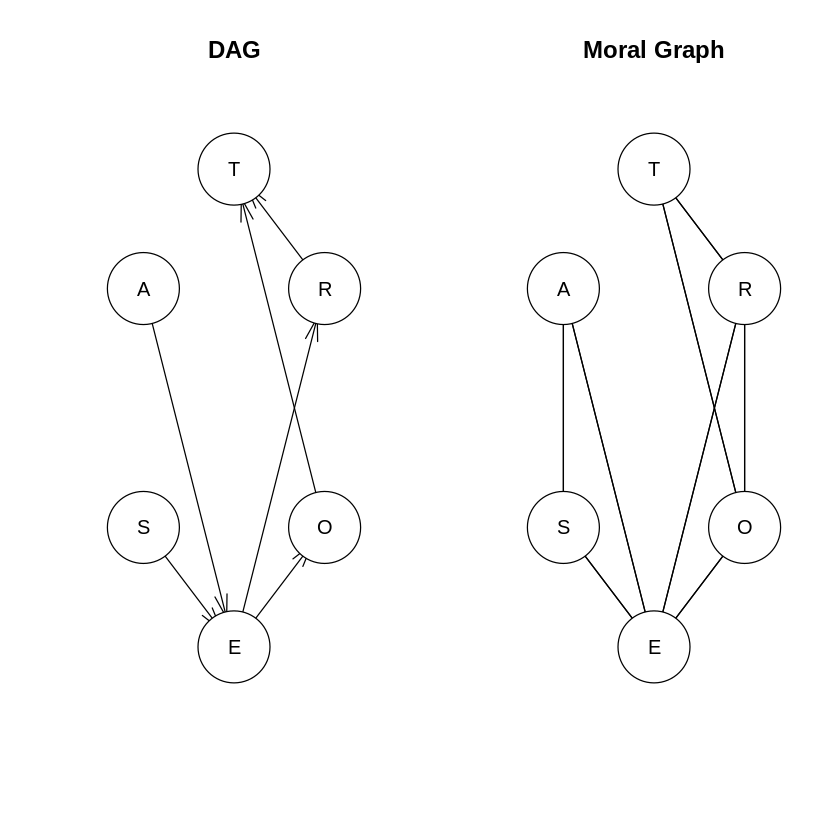

In [52]:
par(mfrow = c(1,2))
plot(dag, main = "DAG")
plot(mdag, main = "Moral Graph")

Como se vió en la parte teórica, este paso es primordial para la generación del árbol de cliques, necesario para realizar la inferencia exacta. Sin embargo, no es necesario realizar todo el proceso de moralización y generación de cliques. La construcción de dicho árbol es inmediata a partir del objeto `bn` usando la función `compile` sobre un objeto de tipo `grain` implementado en la librería `gRain`:

In [53]:
# https://www.rdocumentation.org/packages/gRain/versions/1.3-0
# https://cran.r-project.org/web/packages/gRain/index.html
# http://www.bnlearn.com/documentation/man/gRain.html
# http://www.bnlearn.com/examples/pkg-gRain/
#library(gRain)
junction <- compile(as.grain(bn))

In [54]:
class(junction)

[1] "CPTgrain" "grain"

Una vez creado el árbol (`as.grain`), y las tablas de probabilidad calculadas (`compile`), podemos introducir la nueva evidencia. Las distribuciones locales en cada nodo se actualizan en base a la nueva información introducida, que se propaga a lo largo del árbol. La consulta es realizada a través de la función `querygrain`, que calcula la distribución en los nodos que nos interesan del objeto `junction`.

Por ejemplo, podríamos estar interesados en las actitudes del público femenino respecto al uso del tren o el coche en comparación con la muestra completa de todos los encuestados:

In [56]:
# Esta es la probabilidad marginal de T:
# https://www.rdocumentation.org/packages/gRain/versions/1.3-0/topics/querygrain
print(querygrain(junction, nodes = "T")$T)

T
      car     train     other 
0.5618340 0.2808573 0.1573088 


In [57]:
# Introducimos la nueva evidencia
# https://www.rdocumentation.org/packages/gRain/versions/1.3-0/topics/grain-evidence
jsex <- setEvidence(junction, nodes = "S", states = "F")

In [58]:
class(jsex)

[1] "CPTgrain" "grain"

In [59]:
print(jsex$evidence)

  nodes is.hard.evidence hard.state
1     S             TRUE          F


In [61]:
# Nueva probabilidad marginal dada la evidencia
print(querygrain(jsex, nodes = "T")$T)

T
      car     train     other 
0.5620577 0.2806144 0.1573280 


Según esto, parece que no hay diferencias significativas en las probabilidades derivadas del objeto `junction` antes y después de la llamada a `setEvidence`. Lo primero puede representarse como $P(\mathrm{\texttt{T}})$, mientras que tras introducir la evidencia hemos calculado $P(\mathrm{\texttt{T | S = F}})$. Esto sugiere que las mujeres tienen una preferencia similar hacia el coche o el tren que el total de los encuestados considerados globalmente.

In [63]:
#::GMG::Me pregunto si pasa lo mismo con M ...
#       tampoco parecen diferencias significativas
jsex <- setEvidence(junction, nodes = "S", states = "M")
print(jsex$evidence)
print(querygrain(jsex, nodes = "T")$T)

  nodes is.hard.evidence hard.state
1     S             TRUE          M
T
      car     train     other 
0.5616848 0.2810192 0.1572960 


Otro problema interesante puede ser cómo vivir en una ciudad pequeña puede afectar el uso del tren o del coche, esto es, $P(\mathrm{\texttt{T | R = small}})$. 

In [64]:
jres <- setEvidence(object = junction, nodes = "R", states = "small")
print(jres$evidence)
print(querygrain(jres, nodes = "T")$T)

  nodes is.hard.evidence hard.state
1     R             TRUE      small
T
       car      train      other 
0.48388675 0.41708494 0.09902831 


Ahora la probabilidad asociada con otros medios de transporte (`other`) cae de 0.157 a 0.099 mientras que la probabilidad asociada a `train` se incrementa de 0.281 a 0.417. En conjunto, las probabilidad combinada de `car` y `train` sube de 0.843 (del total de la muestra) a 0.901 (para las personas que viven en ciudades pequeñas). Por lo tanto, puede concluirse que en ciudades pequeñas el medio de transporte preferido es el coche, aunque aumenta la preferencia por el tren.

También podemos utilizar las consultas de probabilidades condicionadas para evaluar la _independencia condicional_, tal y como hicimos en la sección anterior usando el grafo y el comando `dsep`. Volvamos a considerar la relación entre `S` y `T`, esta vez condicionada a la evidencia de que `E = "high"`. La probabilidad conjunta de `S` y `T` dado que el nivel de educación sea `high`, representado por la expresión $P(\mathrm{\texttt{S,T | E = high}})$, se calcula nuevamente usando `setEvidence` y `querygrain` del siguiente modo:

In [65]:
jedu <- setEvidence(junction, nodes = "E", states = "high")

In [66]:
SxT.cpt <- querygrain(jedu, nodes = c("S", "T"), type = "joint")
print(SxT.cpt)

   T
S         car     train      other
  M 0.3426644 0.1736599 0.09623271
  F 0.2167356 0.1098401 0.06086729
attr(,"class")
[1] "parray" "array" 


In [67]:
dsep(dag, "S", "T", "E")

[1] TRUE

Por tanto, el argumento `type` define cual de las posibles distribuciones asociadas a cada nodo es devuelta en la consulta. El valor por defecto es `marginal`, que devuelve las probabilidades marginales:

In [68]:
print(querygrain(jedu, nodes = c("S", "T"), type = "marginal"))

$S
S
       M        F 
0.612557 0.387443 

$T
T
   car  train  other 
0.5594 0.2835 0.1571 



Usando `type = joint` obtenemos, como se ha visto, la probabilidad conjunta. Por último, podemos obtener las probabilidades condicionales. En este caso, `querygrain` devuelve la distribución del primer nodo en `nodes` condicionada al resto de nodos en `nodes` (y por supuesto a la evidencia previamente presentada mediante `setEvidence`):

In [69]:
print(querygrain(jedu, c("S", "T"), type = "conditional"))

       S
T              M        F
  car   0.612557 0.387443
  train 0.612557 0.387443
  other 0.612557 0.387443


En este caso la suma de columnas suma 1, porque se calculan condicionadas al valor de `T` en cada caso.

<!--
# ********************************************************************************
# __Ejercicio__
# 
# 
# ev1 <- setEvidence(junction, nodes = c("S", "E", "T"), states = c("M", "high", "car"))
# querygrain(ev1, nodes = c("S", "T"), type = "conditional")
# 
# 
# 1. Comprueba las probabilidades condicionales dado que `S = M` y `E = high` para cada posible estado de `T`
# 2. Ahora realiza la misma prueba que anteriormente, pero sabiendo que `S = F`
# 3. ¿Qué conclusión podemos extraer a la luz de las probabilidades obtenidas en cada uno de los casos?
# 
# # 1
# jsex.edu <- setEvidence(junction, nodes = c("S", "E"), states = c("M", "high"))
# querygrain(jsex.edu, nodes = c("E","S","T"), type = "conditional")
# 
# # 2
# jsex.edu2 <- setEvidence(junction, nodes = c("S", "E"), states = c("F", "high"))
# querygrain(jsex.edu2, nodes = c("E","S","T"), type = "conditional")
# 
# # 3
# Se puede inferir por tanto que `S`es independiente de `T`condicional a `E`
-->

### 3.3 Inferencia aproximada

El uso de simulaciones de Monte-Carlo constituye una aproximación alternativa al problema de la inferencia, basada en generar observaciones aleatorias a partir de la red bayesiana. Estas observaciones son a su vez utilizadas para estimar las probabilidades condicionales que nos interesen de forma aproximada. 

Este método es caro desde el punto de vista computacional, pero a cambio permite introducir especificaciones de la evidencia más complejas y puede ser preferible en redes complejas. En redes discretas, un método sencillo ampliamente utilizado es el de _rejection sampling_.

De acuerdo con este método, se generan observaciones aleatorias independientes a partir de la red bayesiana. Después, se contabiliza el número de dichas observaciones que coinciden con la evidencia dada por la que estamos condicionando y cuántas observaciones también coinciden con el evento cuya probabilidad queremos estimar; la probabilidad condicional estimada es el ratio entre ésta y aquella.

En `bnlearn`, esta aproximación está implementada a través de las funciones `cpquery` y `cpdist`. `cpquery` devuelve la probabilidad de un evento determinado dada cierta evidencia. Volviendo al primer ejemplo utilizado para ilustrar la inferencia exacta, podemos calcular la primera casilla de la tabla de probabilidades del siguiente modo:

In [70]:
set.seed(1)

In [71]:
print(cpquery(bn, event = (S == "M") & (T == "car"), evidence = (E == "high")))

[1] 0.3514745


Como puede comprobarse, en este caso la probabilidad estimada difiere ligeramente de la que obtuvimos mediante inferencia exacta (0.3427) calculada con `querygrain`, que era $P(\mathrm{\texttt{S = m, T = car | E = high}}) = 0.3427$.

La probabilidad estimada es cercana a su valor verdadero. Esta precisión puede aumentarse aumentando el número de observaciones aleatorias que se genera (argumento `n`, valor por defecto = 5000). Sin embargo, incrementar la precisión tiene su coste: La consulta requiere más tiempo de cálculo, y su precisión podría seguir siendo baja si la evidencia dada tienen una baja probabilidad. Por ejemplo, generamos un millón de observaciones aleatorias para comprobar que ahora nos acercamos más al valor verdadero:

In [72]:
set.seed(1)
print(cpquery(bn, event = (S == "M") & (T == "car"), evidence = (E == "high"), n = 1e06))

[1] 0.3421707


Una aproximación mejor es el pesado de verosimilitudes (_likelihood weighting_). Este método se basa en en generar observaciones aleatorias de tal modo que todas ellas coinciden con la evidencia dada, y asigna pesos a cada una de ellas de forma apropiada para calcular las probabilidades condicionales al realizar la consulta. Se puede aplicar este método con el argumento `method = "lw"` desde la función `cpquery`:

In [73]:
set.seed(2)
print(cpquery(bn, event = (S == "M") & (T == "car"), 
        evidence = list(E = "high"), method = "lw"))

[1] 0.3390615


En este caso, la probabilidad estimada (0.3390) se aproxima bastante a la calculada anteriormente de forma exacta (0.3427) sin necesidad de realizar $10^{6}$ simulaciones.

Como ejemplo de una consulta algo más complicada, podemos intentar calcular la probabilidad de que un hombre viaje en coche dado que su nivel educativo sea universitario o bien que sea un adulto, independientemente de su nivel educativo:


$$
\begin{aligned}
P(\mathrm{\texttt{S = M, T = car | \{A = young,E = uni\}}} \cup \mathrm{\texttt{\{A = adult\}}})
\end{aligned}
$$


, que se especificaría mediante `cpquery` del siguiente modo:

In [74]:
set.seed(1)
print(cpquery(bn, event = (S == "M") & (T == "car"),
        evidence = ((A == "young") & (E == "uni")) | (A == "adult")))

[1] 0.335729


La implementación del método `lw` no es lo suficientemente flexible como para calcular evidencias compuestas como esta; esta limitación existe también para las funciones que realizan la inferencia exacta en el paquete `gRain`. 

La función `cpdist`, con una sintaxis similar a `cpquery`, devuelve un `data.frame` que contienen las observaciones aleatorias para las variables en `nodes` generadas que coinciden con los criterios de la evidencia (`evidence`) dada:

In [75]:
SxT <- cpdist(bn, nodes = c("S", "T"), evidence = (E == "high"))
head(SxT)

S,T
M,train
M,train
M,train
F,train
M,car
M,other


Estas observaciones devueltas por `cpdist` pueden ser utilizadas para otros tipos de inferencia, dando lugar a un método muy versátil. Por ejemplo, podemos calcular la tabla de probabilid conjunta de `S` y `T` dado el nivel `E = "high"` y compararla con la que calculamos utilizando `querygrain` en el ejemplo anterior de inferencia exacta. Para ello, usamos `table` para generar la tabla de contingencia `SxT` y `prop.table` para convertir el conteo en probabilidades, como hemos visto anteriormente en la sección de aprendizaje paramétrico:

In [76]:
prop.table(table(SxT))

   T
S          car      train      other
  M 0.33234421 0.16994875 0.10871325
  F 0.21364985 0.11329916 0.06204478

Como vimos anteriormente, en el grupo con `E="high"`, la combinación más frecuente de sexo y medio de transporte es coche y varón.

## 4 Representación gráfica avanzada

Una de las grandes ventajas de las redes Bayesianas consiste en poder estudiarlas de forma visual a partir de su representación gráfica. A continuación se muestran algunas de las herramientas disponibles en R para la representación gráfica de redes bayesianas.

### 4.1 Dibujar un DAG

`bnlearn` se basa en las herramientas disponibles en el paquete `Rgraphviz` para dibujar estructuras gráficas, a través de la función `graphviz.plot`. De hecho, la llamada a esta función con todos los argumentos por defecto da lugar a los gráficos que hemos visto anteriormente usando directamente `plot`.

Una operación típica es resaltar un nodo(s) en particular. Por ejemplo, si queremos significar una conectividad de tipo convergente ([recuerda aquí](#dag.struc)) en nuestro grafo, podemos hacerlo del siguiente modo: Primero, vamos a definir el color gris para todos los nodos del DAG:

In [77]:
hlight <- list(nodes = nodes(dag), arcs = arcs(dag), col = "grey", textCol = "grey")

A continuación, le pasamos esta lista de especificaciones a la función `graphviz.plot` a través de su argumento `highlight`:

[1] "graphNEL"
attr(,"package")
[1] "graph"

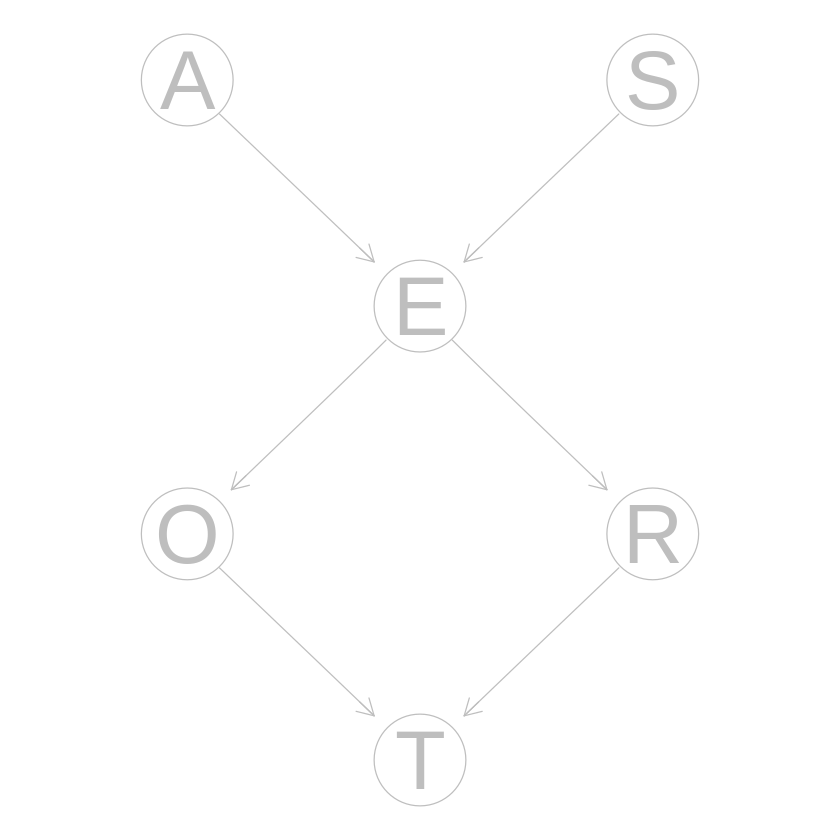

In [78]:
pp <- graphviz.plot(dag, highlight = hlight)
class(pp)

El aspecto de los arcos se puede modificar utilizando `edgeRenderInfo`, y una lista cuyos elementos son los elementos gráficos que se desea modificar:

In [79]:
edgeRenderInfo(pp) <- list(col = c("A~E" = "black", "S~E" = "black"), # color
                           lwd = c("A~E" = 2.5, "S~E" = 2.5)) # grosor

Del mismo modo, manipulamos el aspecto de los nodos con `nodeRenderInfo`:

In [80]:
nodeRenderInfo(pp) <- list(col = c("S" = "black", "E" = "black", "A" = "black"),
                           textCol = c("S" = "black", "E" = "black", "A" = "black"),
                           fill = c("E" = "grey"))

Una vez introducidas todas las modificaciones, se pinta el grafo con `renderGraph`:

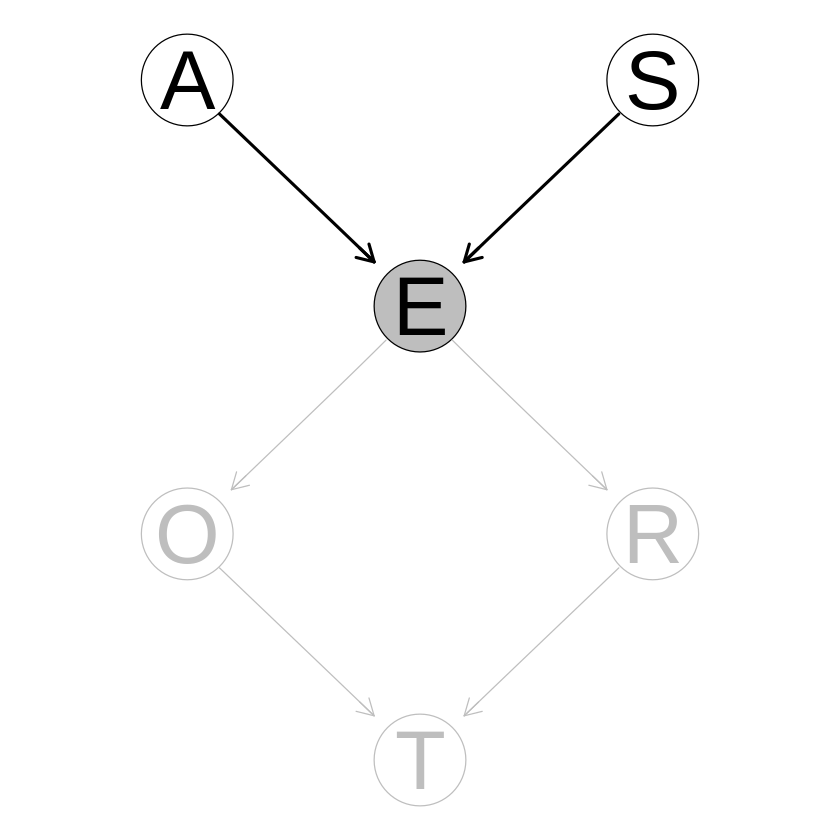

In [81]:
renderGraph(pp)

Otro ejemplo de personalizacion consiste en resaltar las v-estructuras del grafo:

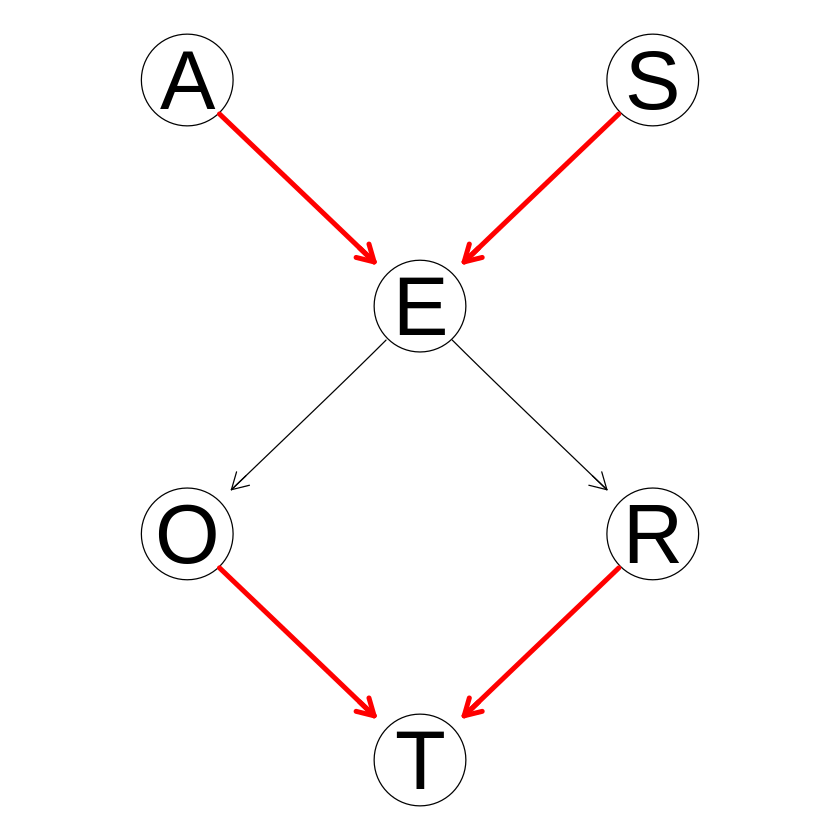

In [82]:
hl <- list(arcs = vstructs(dag, arcs = TRUE), lwd = 4, col = "red")
graphviz.plot(dag, highlight = hl)

Existen además otras posibles configuraciones para representar los DAG. Estas son las alternativas que ofrece la función `graphviz.plot`, y que se encuentran documentadas en la viñeta del paquete `Rgraphviz`:

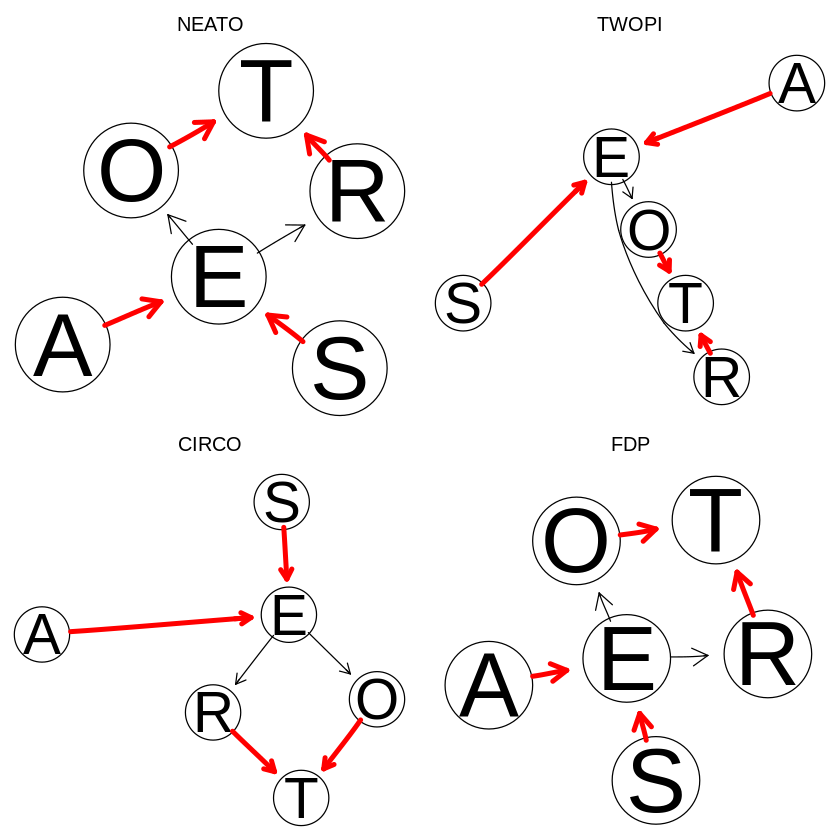

In [83]:
# Valor por defecto (layout = "dot"):
# graphviz.plot(dag, highlight = hl, layout = "dot")
par(mfrow = c(2,2))
for (i in c("neato", "twopi", "circo", "fdp")) {
      graphviz.plot(dag, highlight = hl, layout = i, main = toupper(i))
}

### 4.2 Gráficos de distribución de probabilidades condicionales

Se trata de gráficos de gran utilidad en el análisis y exploración del modelo. Las funciones implementadas en `bnlearn` se basan en las herramientas del potente paquete `lattice` para visualización de datos multivariantes.

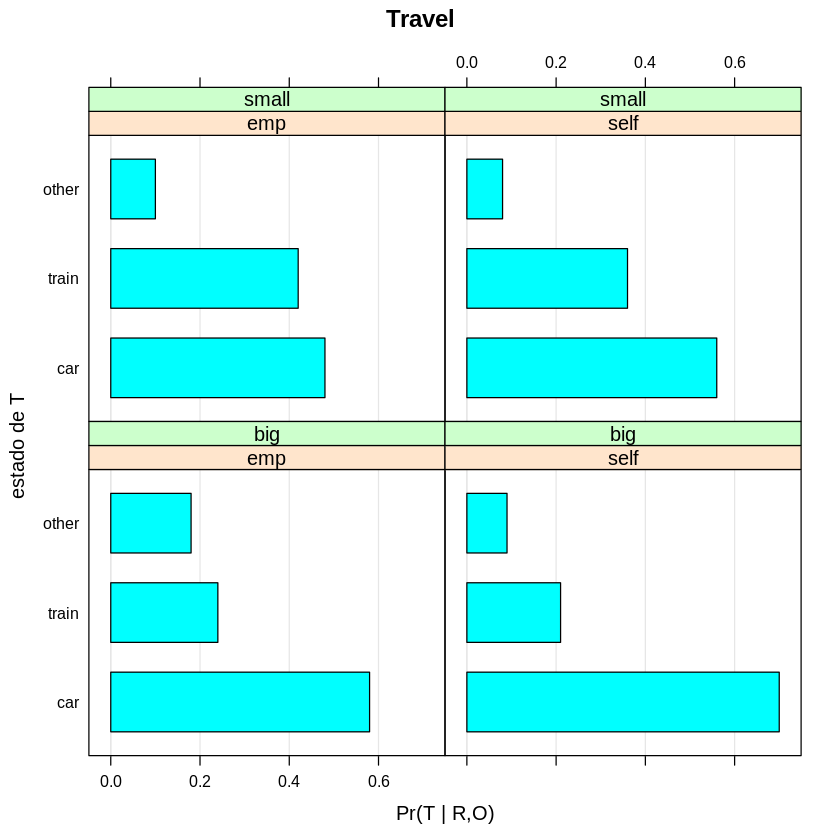

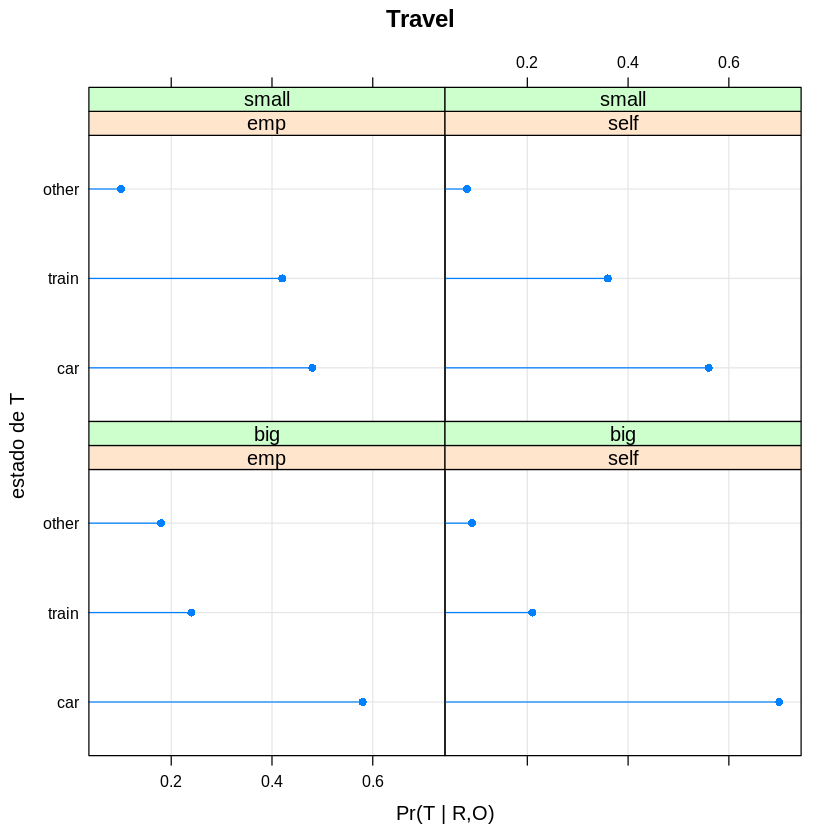

In [84]:
# Barras
bn.fit.barchart(bn$T, main = "Travel", xlab = "Pr(T | R,O)", ylab = "estado de T")
# Puntos
bn.fit.dotplot(bn$T, main = "Travel", xlab = "Pr(T | R,O)", ylab = "estado de T")

## 5 Ejemplo: Clasificador Bayesiano Ingenuo

Definimos la tabla de datos:

In [85]:
variables.Names <- c("Outlook","Temperature","Humidity","Windy","Play Golf")
sample.Number <- c(1:14)
data.table <- array(c("Rainy","Rainy","Overcast","Sunny","Sunny","Sunny","Overcast","Rainy","Rainy","Sunny","Rainy","Overcast","Overcast","Sunny",
                      "Hot","Hot","Hot","Mild","Cool","Cool","Cool","Mild","Cool","Mild","Mild","Mild","Hot","Mild",
                      "High","High","High","High","Normal","Normal","Normal","High","Normal","Normal","Normal","High","Normal","High",
                      "False","True","False","False","False","True","True","False","False","False","True","True","False","True",
                      "No","No","Yes","Yes","Yes","No","Yes","No","Yes","Yes","Yes","Yes","Yes","No"),
                    dim = c(14,5),
                    dimnames = list(event = sample.Number, variable = variables.Names))
estados.O <- c("Rainy","Overcast","Sunny")
estados.T <- c("Hot","Mild","Cool")
estados.H <- c("Normal","High")
estados.W <- c("True","False")
estados.G <- c("Yes","No")

Definimos el grafo:

In [86]:
dag <- empty.graph(nodes = c("O", "T", "H", "W", "G"))
dag <- set.arc(dag, from = "G", to = "O")
dag <- set.arc(dag, from = "G", to = "T")
dag <- set.arc(dag, from = "G", to = "H")
dag <- set.arc(dag, from = "G", to = "W")
modelstring(dag)

[1] "[G][O|G][T|G][H|G][W|G]"

Representamos el grafo:

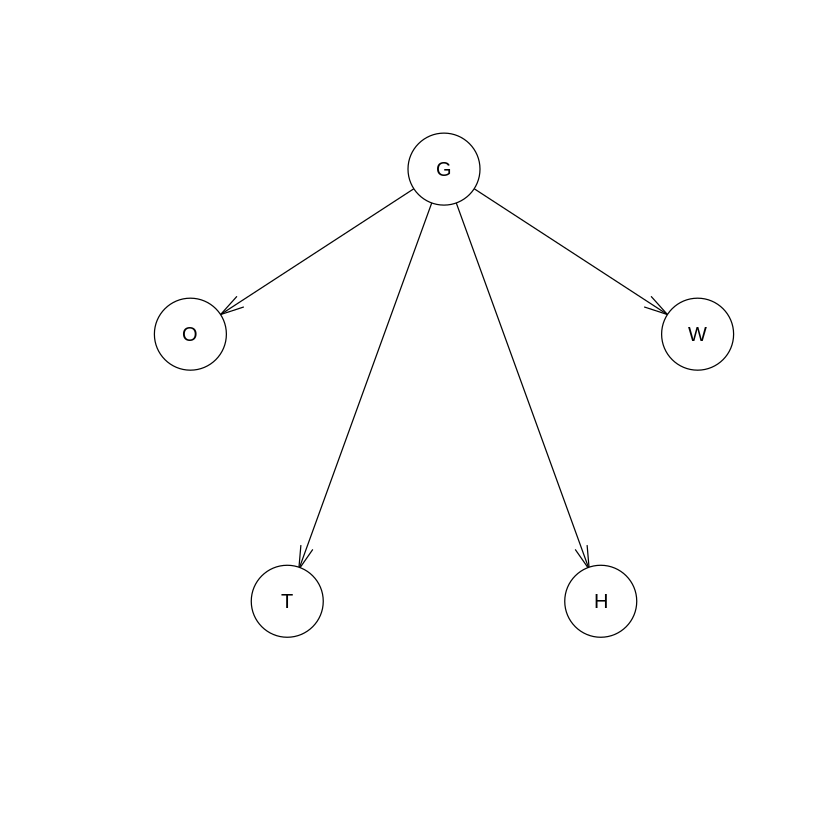

In [87]:
plot(dag)

Definimos las tablas de probabilidad:

In [88]:
G.prob <- array(c(length(which(data.table[,"Play Golf"] == "Yes")), 
                  length(which(data.table[,"Play Golf"] == "No")))/length(data.table[,"Play Golf"]), 
                dim = 2, 
                dimnames = list(G = estados.G))
O.prob <- array(data = 0, 
                dim = c(length(estados.O),length(estados.G)), 
                dimnames = list(O = estados.O, G = estados.G))
T.prob <- array(data = 0, 
                dim = c(length(estados.T),length(estados.G)), 
                dimnames = list(T = estados.T, G = estados.G))
H.prob <- array(data = 0, 
                dim = c(length(estados.H),length(estados.G)), 
                dimnames = list(H = estados.H, G = estados.G))
W.prob <- array(data = 0, 
                dim = c(length(estados.W),length(estados.G)), 
                dimnames = list(W = estados.W, G = estados.G))

In [89]:
for (g in 1:length(estados.G)){
  for (o in 1:length(estados.O)){
    O.prob[o,g] <- length(which(data.table[,"Play Golf"] == estados.G[g] & 
                                data.table[,"Outlook"] == estados.O[o]))/length(which(data.table[,"Play Golf"] == estados.G[g]))
  }
  for (t in 1:length(estados.T)){
    T.prob[t,g] <- length(which(data.table[,"Play Golf"] == estados.G[g] & 
                                data.table[,"Temperature"] == estados.T[t]))/length(which(data.table[,"Play Golf"] == estados.G[g]))
  }
  for (h in 1:length(estados.H)){
    H.prob[h,g] <- length(which(data.table[,"Play Golf"] == estados.G[g] & 
                                data.table[,"Humidity"] == estados.H[h]))/length(which(data.table[,"Play Golf"] == estados.G[g]))
  }
  for (w in 1:length(estados.W)){
    W.prob[w,g] <- length(which(data.table[,"Play Golf"] == estados.G[g] & 
                                data.table[,"Windy"] == estados.W[w]))/length(which(data.table[,"Play Golf"] == estados.G[g]))
  }
}

Con el grafo y la tabla de probabilidades podemos definir la Red Bayesiana:

In [90]:
cpt <- list(G = G.prob, O = O.prob, T = T.prob, H = H.prob, W = W.prob)
bn <- custom.fit(dag, cpt)

¿Se podría jugar al Golf hoy? 

In [91]:
#library(gRain)
junction <- compile(as.grain(bn))

Considerando la inferencia exacta:

In [92]:
jsex <- setEvidence(junction, nodes = c("O","T","H","W"), states = c("Overcast","Cool","Normal","True"))
print(querygrain(jsex, nodes = "G")$G)

G
Yes  No 
  1   0 


Considerando la inferencia aproximada:

In [93]:
set.seed(1)
cpquery(bn, event = (G == "Yes"),
        evidence = ((O == "Overcast") & (T == "Cool") & (H == "Normal") & (W == "True")))

[1] 1

##  6 Referencias

* Gutiérrez, J.M., Cano, R., Cofiño, A.S., Sordo, C., 2004. Redes probabilísticas y neuronales en las ciencias atmosféricas. Centro de Publicaciones, Ministerio de Medio Ambiente, Madrid, Spain.

* Scutari, M., Denis, J.-B., 2014. Bayesian networks: with examples in R.

* Scutari, M., 2014. Bayesian Network Constraint-Based Structure Learning Algorithms: Parallel and Optimised Implementations in the bnlearn R Package. http://arxiv.org/abs/1406.7648

* r-bayesian-networks. http://www.r-bayesian-networks.org/ (Last accessed 18 Nov 2017)

* Nagarajan, R., Scutari, M. and Lèbre, S. 2013. Bayesian networks in R: with applications in systems biology, Use R! Springer, New York.

## 7 Session info

In [94]:
print(sessionInfo())

R version 3.4.4 (2018-03-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] Rgraphviz_2.22.0    gRain_1.3-0         gRbase_1.8-3.4     
[4] RBGL_1.54.0         graph_1.56.0        BiocGenerics_0.24.0
[7] bnlearn_4.4.1      

loaded via a namespace (and not attached):
 [1] igraph_1.2.2         Rcpp_1.0.0           mag

## ::GMG:: Mis notas de clase

In [2]:
dag <- empty.graph(nodes = c("Play", "O", "T", "H", "W"))

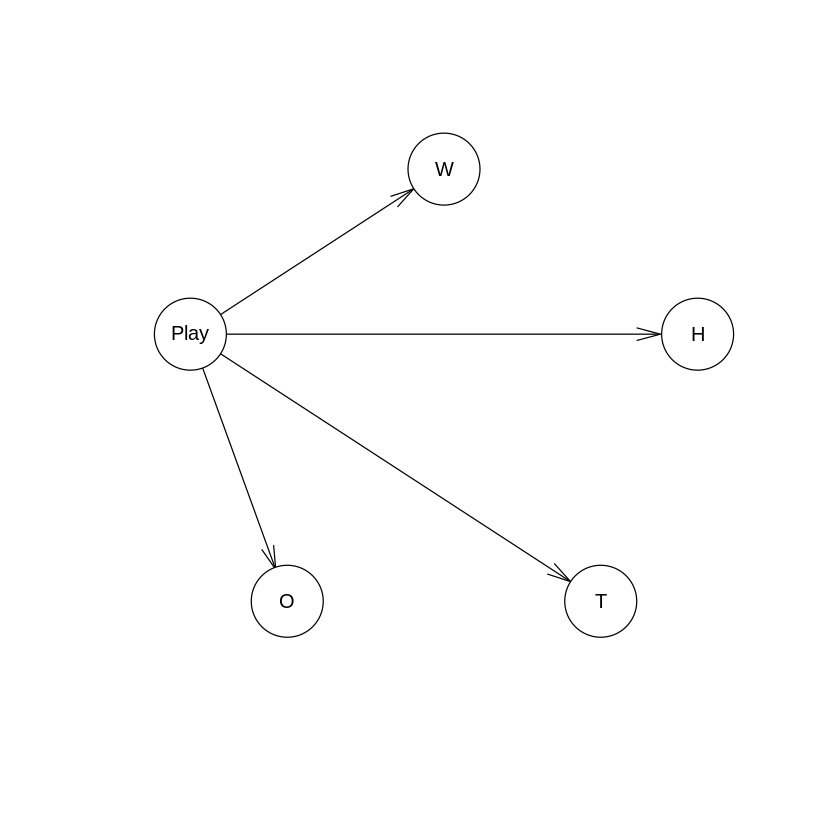

In [3]:
dag <- set.arc(dag, from = "Play", to = "O") 
dag <- set.arc(dag, from = "Play", to = "T") 
dag <- set.arc(dag, from = "Play", to = "H") 
dag <- set.arc(dag, from = "Play", to = "W") 
plot (dag)

In [5]:
#::GMG::Factorización
modelstring(dag)

[1] "[Play][O|Play][T|Play][H|Play][W|Play]"

In [6]:
estados.Play <- c("Yes", "No")
estados.O <- c("Rainy", "Overcast", "Sunny")
estados.T <- c("Hot", "Mild", "Cold")
estados.H <- c("High","Normal")
estados.W <- c("False","True")

In [11]:
tennis <- read.csv('data/tennis.csv')

In [12]:
str(tennis)

'data.frame':	14 obs. of  5 variables:
 $ outlook : Factor w/ 3 levels "overcast","rainy",..: 3 3 1 2 2 2 1 3 3 2 ...
 $ temp    : Factor w/ 3 levels "cool","hot","mild": 2 2 2 3 1 1 1 3 1 3 ...
 $ humidity: Factor w/ 2 levels "high","normal": 1 1 1 1 2 2 2 1 2 2 ...
 $ windy   : Factor w/ 2 levels "false","true": 1 2 1 1 1 2 2 1 1 1 ...
 $ play    : Factor w/ 2 levels "no","yes": 1 1 2 2 2 1 2 1 2 2 ...


In [16]:
# https://stackoverflow.com/questions/27969616/add-column-sum-to-table
O_prob <- table(tennis$outlook, tennis$play)
O_prob

          
           no yes
  overcast  0   4
  rainy     2   3
  sunny     3   2

In [17]:
O_prob <- rbind(O_prob, Total = colSums(O_prob))

In [18]:
O_prob

,no,yes
overcast,0,4
rainy,2,3
sunny,3,2
Total,5,9


In [ ]:
#::GMG::todos los hijos tienen un padre
# nrows es el de las variables hijas
# ncols es el número de estados de play
# https://www.geeksforgeeks.org/naive-bayes-classifiers/
